In [1328]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


In [1329]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')

X = df.drop("purchaseValue",axis=1)
Y = df["purchaseValue"]

In [1330]:
X_predict = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

In [1331]:
print(list(X.columns))

['trafficSource.isTrueDirect', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'totals.bounces', 'date', 'device.language', 'deviceType', 'userChann

In [1332]:
not_available_in_demo = ['device.screenResolution','device.mobileDeviceBranding','device.mobileInputSelector','device.mobileDeviceMarketingName',
                         'device.operatingSystemVersion','device.flashVersion','geoNetwork.networkLocation','browserMajor','device.browserSize',
                         'device.mobileDeviceModel','device.language','device.browserVersion','device.screenColors']
pk = ['userId','sessionId']
single_value = ['screenSize','totals.visits','socialEngagementType','locationZone']

categorical = ['browser','geoCluster','trafficSource.adwordsClickInfo.slot','geoNetwork.networkDomain','os','geoNetwork.subContinent',
               'trafficSource.medium','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.page','deviceType','userChannel'
               ,'geoNetwork.continent']
too_much_categorical = ['geoNetwork.region','trafficSource','locationCountry','geoNetwork.city','geoNetwork.metro','trafficSource.referralPath']
numerical = ['pageViews','totalHits','sessionNumber']
boolean = ['trafficSource.isTrueDirect','gclIdPresent','trafficSource.adwordsClickInfo.isVideoAd','totals.bounces','device.isMobile']
textual = ['trafficSource.adContent','trafficSource.keyword','trafficSource.campaign']
date = ['date']

In [1333]:
X_predict['trafficSource'].value_counts()

trafficSource
google                    11112
(direct)                   9247
youtube.com                4737
mall.googleplex.com        1536
analytics.google.com        504
                          ...  
googleux.perksplus.com        1
google.es                     1
google.hu                     1
google.ca                     1
au.search.yahoo.com           1
Name: count, Length: 91, dtype: int64

In [1334]:
print(df[['date','sessionStart']])

            date  sessionStart
0       20170714    1500100799
1       20170519    1495262065
2       20171020    1508510328
3       20170103    1483431838
4       20161006    1475804633
...          ...           ...
116018  20170717    1500318402
116019  20161108    1478624150
116020  20160805    1470384216
116021  20171002    1506953297
116022  20170730    1501474532

[116023 rows x 2 columns]


In [1335]:
print(df.shape)

(116023, 52)


In [1336]:
print(df['new_visits'].value_counts())

new_visits
1.0    80518
Name: count, dtype: int64


In [1337]:
print(df[df['new_visits']!=1.0]['purchaseValue'].mean()-df[df['new_visits']==1.0]['purchaseValue'].mean())

54795237.33733245


In [1338]:
print(df[['geoNetwork.continent','geoNetwork.subContinent']].value_counts())

geoNetwork.continent  geoNetwork.subContinent
Americas              Northern America           63596
Asia                  Southeast Asia              7151
                      Southern Asia               6484
Europe                Western Europe              6264
                      Northern Europe             5998
Asia                  Eastern Asia                5036
Americas              South America               4336
Europe                Eastern Europe              4277
                      Southern Europe             3755
Asia                  Western Asia                3581
Americas              Central America             1675
Oceania               Australasia                 1588
Africa                Northern Africa              929
                      Western Africa               315
                      Southern Africa              264
Americas              Caribbean                    249
Africa                Eastern Africa               193
(not set)          

In [1339]:
print(df[df['totals.bounces']==1.0]['purchaseValue'].value_counts())

purchaseValue
0.0    47148
Name: count, dtype: int64


In [1340]:
req_cols = categorical+too_much_categorical+numerical+boolean+textual+date+['sessionStart']
X = X[req_cols]
X_predict = X_predict[req_cols]

In [1341]:
X.shape

(116023, 31)

In [1342]:
X_predict.shape

(29006, 31)

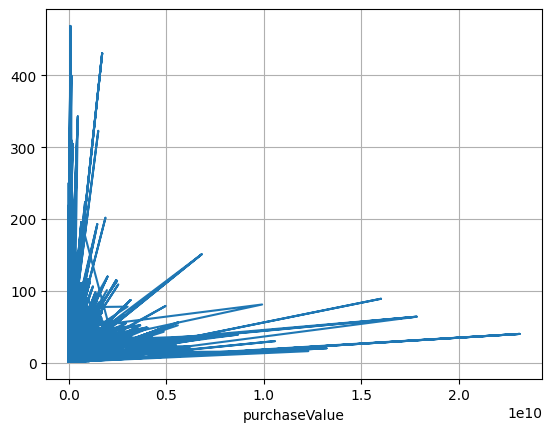

In [1343]:
import matplotlib.pyplot as plt

plt.plot(df['purchaseValue'],df['pageViews'])
plt.xlabel('purchaseValue')
plt.grid(True)
plt.show()


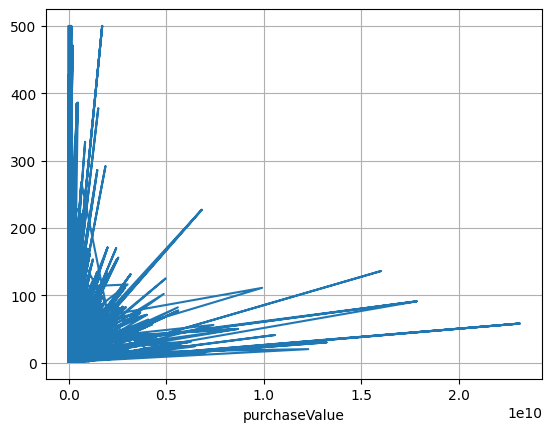

In [1344]:
plt.plot(df['purchaseValue'],df['totalHits'])
plt.xlabel('purchaseValue')
plt.grid(True)
plt.show()

In [1345]:
X['date'] = pd.to_datetime(X['date'], format='%Y%m%d')
X_predict['date'] = pd.to_datetime(X_predict['date'], format='%Y%m%d')

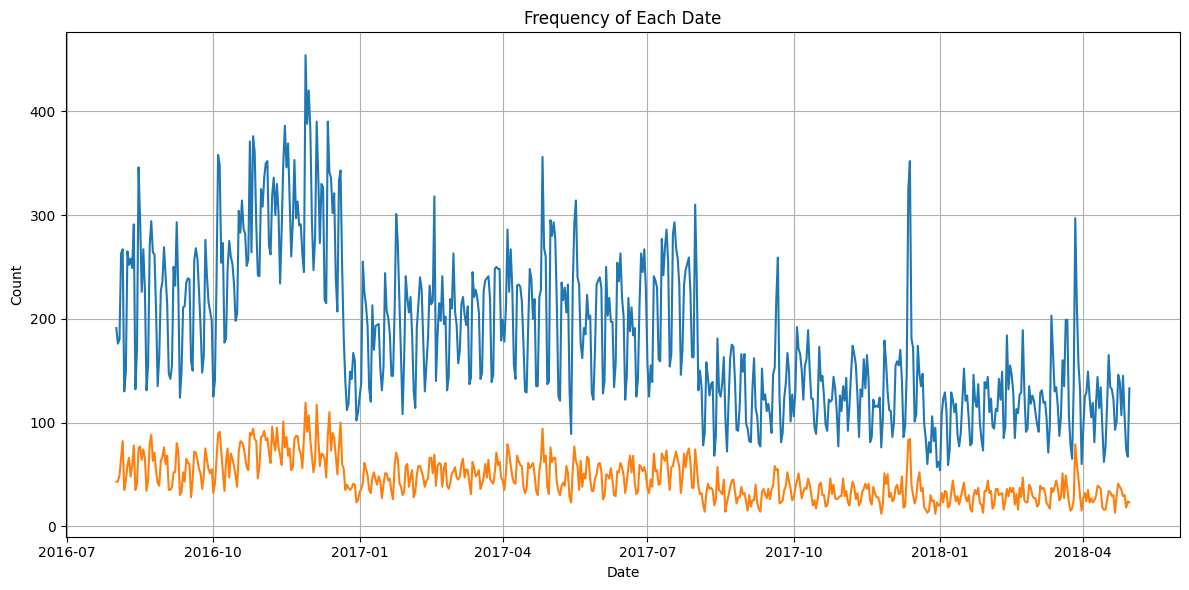

In [1346]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
date_counts1 = X['date'].value_counts().sort_index()
date_counts2 = X_predict['date'].value_counts().sort_index()

plt.plot(date_counts1.index, date_counts1.values, label='train')
plt.plot(date_counts2.index, date_counts2.values, label='predict')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Frequency of Each Date')
plt.grid(True)
plt.tight_layout()
plt.show()


In [1347]:
for elem in [X,X_predict]:
    elem['year'] = elem['date'].dt.year
    elem['month'] = elem['date'].dt.month
    elem['dayofweek'] = elem['date'].dt.dayofweek
    elem['is_weekend'] = elem['dayofweek'] >= 5
    elem.drop(['date'],inplace=True,axis=1)
    elem['dow_sin'] = np.sin(2 * np.pi * elem['dayofweek'] / 7)
    elem['dow_cos'] = np.cos(2 * np.pi * elem['dayofweek'] / 7)
    elem['month_sin'] = np.sin(2 * np.pi * elem['month'] / 12)
    elem['month_cos'] = np.cos(2 * np.pi * elem['month'] / 12)
    
date.clear()
date = ['year','month','is_weekend']
numerical += date
categorical += ['dayofweek']
date.clear()

In [1348]:
print(X['year'].value_counts())

year
2017    62926
2016    38787
2018    14310
Name: count, dtype: int64


In [1349]:
pd.to_datetime(X['sessionStart'],unit='s')

0        2017-07-15 06:39:59
1        2017-05-20 06:34:25
2        2017-10-20 14:38:48
3        2017-01-03 08:23:58
4        2016-10-07 01:43:53
                 ...        
116018   2017-07-17 19:06:42
116019   2016-11-08 16:55:50
116020   2016-08-05 08:03:36
116021   2017-10-02 14:08:17
116022   2017-07-31 04:15:32
Name: sessionStart, Length: 116023, dtype: datetime64[ns]

In [1350]:
for elem in [X,X_predict]:
    elem['sessionStart'] = pd.to_datetime(elem['sessionStart'], unit='s')
    elem['hour_session'] = elem['sessionStart'].dt.hour # ise one hot encode kr lunga
    elem['dayofweek_session'] = elem['sessionStart'].dt.dayofweek
    elem['is_weekend_session'] = elem['dayofweek_session'].isin([5, 6]).astype(int)
    elem['isnight_session'] = elem['hour_session'].apply(lambda h: 1 if h < 6 or h >= 22 else 0)
    elem['hour_sin'] = np.sin(2 * np.pi * elem['hour_session'] / 24)
    elem['hour_cos'] = np.cos(2 * np.pi * elem['hour_session'] / 24)
    elem['is_weekend_night_session'] = elem['is_weekend_session']*elem['isnight_session']
    elem['dow_sin_session'] = np.sin(2 * np.pi * elem['dayofweek_session'] / 7)
    elem['dow_cos_session'] = np.cos(2 * np.pi * elem['dayofweek_session'] / 7)
    elem = elem.drop(['sessionStart'],axis=1)

In [1351]:
print(X.columns)

Index(['browser', 'geoCluster', 'trafficSource.adwordsClickInfo.slot',
       'geoNetwork.networkDomain', 'os', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.page', 'deviceType', 'userChannel',
       'geoNetwork.continent', 'geoNetwork.region', 'trafficSource',
       'locationCountry', 'geoNetwork.city', 'geoNetwork.metro',
       'trafficSource.referralPath', 'pageViews', 'totalHits', 'sessionNumber',
       'trafficSource.isTrueDirect', 'gclIdPresent',
       'trafficSource.adwordsClickInfo.isVideoAd', 'totals.bounces',
       'device.isMobile', 'trafficSource.adContent', 'trafficSource.keyword',
       'trafficSource.campaign', 'sessionStart', 'year', 'month', 'dayofweek',
       'is_weekend', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
       'hour_session', 'dayofweek_session', 'is_weekend_session',
       'isnight_session', 'hour_sin', 'hour_cos', 'is_weekend_night_session',
 

In [1352]:
d1 = (X['browser'].value_counts())
d2 = (X_predict['browser'].value_counts())
d1 = dict(d1)
d2 = dict(d2)
for i in d1:
    if i not in d2:
        X['browser'] = X['browser'].replace(i,'(not set)')

for i in d2:
    if i not in d1:
        X_predict['browser'] = X_predict['browser'].replace(i,'(not set)')

In [1353]:
d1 = (X['os'].value_counts())
d2 = (X_predict['os'].value_counts())
d1 = dict(d1)
d2 = dict(d2)
for i in d1:
    if i not in d2:
        X['os'] = X['os'].replace(i,'(not set)')

for i in d2:
    if i not in d1:
        X_predict['os'] = X_predict['os'].replace(i,'(not set)')

In [1354]:
# d1 = (X['trafficSource'].value_counts())
# d2 = (X_predict['trafficSource'].value_counts())
# d1 = dict(d1)
# d2 = dict(d2)
# for i in d1:
#     if i not in d2:
#         X['trafficSource'] = X['trafficSource'].replace(i,'(not set)')

# for i in d2:
#     if i not in d1:
#         X_predict['trafficSource'] = X_predict['trafficSource'].replace(i,'(not set)')

In [1355]:
# pattern = r"\{KeyWord:(.*?)\}"
# X['trafficSource.adContent'] = X['trafficSource.adContent'].astype(str).str.replace(pattern, r"\1", regex=True)
# X_predict['trafficSource.adContent'] = X_predict['trafficSource.adContent'].astype(str).str.replace(pattern, r"\1", regex=True)

In [1356]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=100)
# X_tfidf = tfidf.fit_transform(X['trafficSource.adContent'])

# tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"tfidf_{word}" for word in tfidf.get_feature_names_out()])
# X = pd.concat([X.drop(columns=['trafficSource.adContent']).reset_index(drop=True),tfidf_df.reset_index(drop=True)], axis=1)

# X_tfidf = tfidf.transform(X_predict['trafficSource.adContent'])
# tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"tfidf_{word}" for word in tfidf.get_feature_names_out()])
# X_predict = pd.concat([X_predict.drop(columns=['trafficSource.adContent']).reset_index(drop=True),tfidf_df.reset_index(drop=True)], axis=1)

In [1357]:
X['pageViews'] = X['pageViews'].fillna(X['pageViews'].mean())
X_predict['pageViews'] = X_predict['pageViews'].fillna(X['pageViews'].mean())

In [1358]:
X['trafficSource.adwordsClickInfo.adNetworkType'] = X['trafficSource.adwordsClickInfo.adNetworkType'].fillna('not set')
X_predict['trafficSource.adwordsClickInfo.adNetworkType'] = X_predict['trafficSource.adwordsClickInfo.adNetworkType'].fillna('not set')

In [1359]:
X['trafficSource.adwordsClickInfo.slot'] = X['trafficSource.adwordsClickInfo.slot'].fillna('unknown')
X_predict['trafficSource.adwordsClickInfo.slot'] = X_predict['trafficSource.adwordsClickInfo.slot'].fillna('unknown')
X['trafficSource.adwordsClickInfo.slot'] = X['trafficSource.adwordsClickInfo.slot'].replace('Google Display Network','unknown')

In [1360]:
X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].fillna(0)
X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].replace(True,1)
X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].astype(int)

X_predict['trafficSource.isTrueDirect'] = X_predict['trafficSource.isTrueDirect'].fillna(0)
X_predict['trafficSource.isTrueDirect'] = X_predict['trafficSource.isTrueDirect'].replace(True,1)
X_predict['trafficSource.isTrueDirect'] = X_predict['trafficSource.isTrueDirect'].astype(int)

/tmp/ipykernel_31/2167355588.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].replace(True,1)
/tmp/ipykernel_31/2167355588.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_predict['trafficSource.isTrueDirect'] = X_predict['trafficSource.isTrueDirect'].replace(True,1)


In [1361]:
X['device.isMobile'] = X['device.isMobile'].replace(False,0)
X['device.isMobile'] = X['device.isMobile'].replace(True,1)
X['device.isMobile'] = X['device.isMobile'].astype(int)

X_predict['device.isMobile'] = X_predict['device.isMobile'].replace(False,0)
X_predict['device.isMobile'] = X_predict['device.isMobile'].replace(True,1)
X_predict['device.isMobile'] = X_predict['device.isMobile'].astype(int)

/tmp/ipykernel_31/1181391405.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['device.isMobile'] = X['device.isMobile'].replace(True,1)
/tmp/ipykernel_31/1181391405.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_predict['device.isMobile'] = X_predict['device.isMobile'].replace(True,1)


In [1362]:
X['trafficSource.adwordsClickInfo.isVideoAd'] = X['trafficSource.adwordsClickInfo.isVideoAd'].fillna(1)
X['trafficSource.adwordsClickInfo.isVideoAd'] = X['trafficSource.adwordsClickInfo.isVideoAd'].replace(False,0)
X['trafficSource.adwordsClickInfo.isVideoAd'] = X['trafficSource.adwordsClickInfo.isVideoAd'].astype(int)

X_predict['trafficSource.adwordsClickInfo.isVideoAd'] = X_predict['trafficSource.adwordsClickInfo.isVideoAd'].fillna(1)
X_predict['trafficSource.adwordsClickInfo.isVideoAd'] = X_predict['trafficSource.adwordsClickInfo.isVideoAd'].replace(False,0)
X_predict['trafficSource.adwordsClickInfo.isVideoAd'] = X_predict['trafficSource.adwordsClickInfo.isVideoAd'].astype(int)

/tmp/ipykernel_31/2983323809.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['trafficSource.adwordsClickInfo.isVideoAd'] = X['trafficSource.adwordsClickInfo.isVideoAd'].replace(False,0)
/tmp/ipykernel_31/2983323809.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_predict['trafficSource.adwordsClickInfo.isVideoAd'] = X_predict['trafficSource.adwordsClickInfo.isVideoAd'].replace(False,0)


In [1363]:
X['geoNetwork.region'].value_counts()

geoNetwork.region
not available in demo dataset    60138
California                       18122
New York                          5634
(not set)                         2806
Illinois                          1625
                                 ...  
Djong Thap Province                  1
Krasnodar Krai                       1
Overijssel                           1
Sardinia                             1
Puebla                               1
Name: count, Length: 388, dtype: int64

In [1364]:
X_predict['geoNetwork.region'].value_counts()

geoNetwork.region
not available in demo dataset    14991
California                        4467
New York                          1499
(not set)                          696
Illinois                           441
                                 ...  
Corsica                              1
State of Pernambuco                  1
State of Espirito Santo              1
Miaoli County                        1
Alaska                               1
Name: count, Length: 287, dtype: int64

In [1365]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 47 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   browser                                       116023 non-null  object        
 1   geoCluster                                    116023 non-null  object        
 2   trafficSource.adwordsClickInfo.slot           116023 non-null  object        
 3   geoNetwork.networkDomain                      116023 non-null  object        
 4   os                                            116023 non-null  object        
 5   geoNetwork.subContinent                       116023 non-null  object        
 6   trafficSource.medium                          116023 non-null  object        
 7   trafficSource.adwordsClickInfo.adNetworkType  116023 non-null  object        
 8   trafficSource.adwordsClickInfo.page           4281 non

In [1366]:
onehot = ['browser','geoCluster','os','userChannel','deviceType','dayofweek','geoNetwork.subContinent',
          'trafficSource.medium','trafficSource.adwordsClickInfo.adNetworkType','geoNetwork.networkDomain'
          ,'trafficSource.adwordsClickInfo.slot','locationCountry','dayofweek_session'] #hour_session 

numerical = ['pageViews', 'totalHits', 'year', 'month', 'is_weekend','trafficSource.isTrueDirect',
             'gclIdPresent','device.isMobile','trafficSource.adwordsClickInfo.isVideoAd','sessionNumber',
             'isnight_session','is_weekend_session','month_sin','month_cos','dow_sin','dow_cos','hour_sin','hour_cos','is_weekend_night_session'
            ,'dow_sin_session','dow_cos_session']

d = {'totals.bounces':1.0,'trafficSource.adwordsClickInfo.page':[2.0,3.0,4.0,5.0]} 

In [1367]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=1000)

In [1368]:
X_train[onehot+numerical].shape

(92818, 34)

In [1369]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import ExtraTreesRegressor

numpipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), onehot),
        ('num', numpipeline, numerical)
    ],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('select', SelectKBest(f_regression, k=50)),
    # ('regressor', HistGradientBoostingRegressor()) # 0.11,0.36
    # ('regressor',lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.05,max_depth=7,random_state=42)) # 0.25,0.46
    # ('regressor',DecisionTreeRegressor()) # this has weird score, look into it
    # ('regressor',RandomForestRegressor(n_estimators=100, random_state=42)) # 0.575 test score, sus, but gotta try submitting it 
    # ('regressor',lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.05,max_depth=15,num_leaves=31,colsample_bytree=0.7,subsample=0.7,random_state=42,n_jobs=-1)) # lowered the training, but same test
    # ('regressor',RandomForestRegressor(n_estimators=300,max_depth=None,min_samples_split=2,min_samples_leaf=1,max_features=0.5,bootstrap=True,n_jobs=-1, random_state=42)) # 0.41,0.576
    ('regressor', XGBRegressor(n_estimators=3000,learning_rate=0.05,max_depth=7,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0, n_jobs=-1,random_state=42,verbosity=1))
    # ('regressor', ExtraTreesRegressor(n_estimators=2500,max_features=0.8,min_samples_split=2,min_samples_leaf=1, bootstrap=False,n_jobs=-1,random_state=42,verbose=1))
])

model.fit(X_train[onehot+numerical], Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['browser', 'geoCluster',
                                                   'os', 'userChannel',
                                                   'deviceType', 'dayofweek',
                                                   'geoNetwork.subContinent',
                                                   'trafficSource.medium',
                                                   'trafficSource.adwordsClickInfo.adNetworkType',
                                                   'geoNetwork.networkDomain',
                                                   'tra...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=3000, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [1370]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

numpipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), onehot),
        ('num', numpipeline, numerical)
    ],
    remainder='passthrough'
)

model1 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    # ('classifier',XGBClassifier(n_estimators=2000,learning_rate=0.05,max_depth=7,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0,use_label_encoder=False,n_jobs=-1,random_state=42))
    # ('classifier', RandomForestClassifier(n_estimators=1000,max_depth=None,max_features='sqrt',min_samples_split=2,min_samples_leaf=1,bootstrap=True,n_jobs=-1,random_state=42))
    ('classifier',LGBMClassifier(n_estimators=1000,learning_rate=0.05,max_depth=7,num_leaves=31,subsample=0.8,colsample_bytree=0.8,random_state=42,n_jobs=-1))
])

model1.fit(X_train[onehot+numerical],(Y_train!=0).astype(int))

[LightGBM] [Info] Number of positive: 19220, number of negative: 73598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16073
[LightGBM] [Info] Number of data points in the train set: 92818, number of used features: 438
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207072 -> initscore=-1.342666
[LightGBM] [Info] Start training from score -1.342666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['browser', 'geoCluster',
                                                   'os', 'userChannel',
                                                   'deviceType', 'dayofweek',
                                                   'geoNetwork.subContinent',
                                                   'trafficSource.medium',
                                                   'trafficSource.adwordsClickInfo.adNetworkType',
                                                   'geoNetwork.networkDomain',
                                                   'tra...
                                                   'trafficSource.adwordsClickInfo.isVideoAd',
                                                   'sessionNumber',
                                                   'isnight_session',
                                                   'is_weekend_session',
                                                   'month_sin', 'month_cos',
                                                   'dow_sin', 'dow_cos',
                                                   'hour_sin', 'hour_cos',
                                                   'is_weekend_night_session',
                                                   'dow_sin_session',
                                                   'dow_cos_session'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                max_depth=7, n_estimators=1000, n_jobs=-1,
                                random_state=42, subsample=0.8))])

In [1371]:
Y_test_pred = model.predict(X_test[onehot+numerical])
Y_test_pred = Y_test_pred * model1.predict(X_test[onehot+numerical])
condition = (X_test['totals.bounces'] == 1.0) | (X_test['trafficSource.adwordsClickInfo.page'].isin([2.0, 3.0, 4.0, 5.0]))
Y_test_pred[condition] = 0
Y_test_pred = np.maximum(Y_test_pred,0)

Y_train_pred = model.predict(X_train[onehot+numerical])
Y_train_pred = Y_train_pred * model1.predict(X_train[onehot+numerical])
condition = (X_train['totals.bounces'] == 1.0) | (X_train['trafficSource.adwordsClickInfo.page'].isin([2.0, 3.0, 4.0, 5.0]))
Y_train_pred[condition] = 0
Y_train_pred = np.maximum(Y_train_pred, 0)


from sklearn.metrics import r2_score
print(r2_score(Y_train,Y_train_pred))
print(r2_score(Y_test,Y_test_pred))

# 0.9918957952286681 -> without classification, sessions
# 0.6677452891234841

# 0.9896089070243331 -> With classiificaion (lgbm)
# 0.6722030211907952

# 0.9903840378835952 -> All features (lgbm)
# 0.6754304267702345

# 0.9943920282774533 -> session updating
# 0.6831037748715769

0.9962907171558258
0.686848723082425


now i need to do something for overfitting thats it.

In [1372]:
Y_predict = model.predict(X_predict[onehot+numerical])
Y_preidct = Y_predict * model1.predict(X_predict[onehot+numerical])
condition = (X_predict['totals.bounces'] == 1.0) | (X_predict['trafficSource.adwordsClickInfo.page'].isin([2.0, 3.0, 4.0, 5.0]))
Y_predict[condition] = 0
Y_predict = np.maximum(Y_predict, 0)

In [1373]:
Y = pd.DataFrame({'id': range(len(Y_predict)), 'purchaseValue': Y_predict})
Y.to_csv("/kaggle/working/submission.csv",index=False)